In [12]:
import importlib
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from Faz1_MultiLabel_File_Dataset import utils
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Sequential
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
importlib.reload(utils)

ORIGINAL_DATA_PATH = "datasets/CSV_Multi_Label_Classification"
AUGMENTED_DATA_PATH = "datasets/CSV_Multi_Label_Classification_Augmented"
tf.test.is_built_with_cuda()


True

In [2]:
print("TensorFlow version:", tf.__version__)
print("GPU Build Info:", tf.sysconfig.get_build_info())
print("GPU Devices:", tf.config.list_physical_devices('GPU'))

# Bellek optimizasyonu (GPU kullanımı için)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)#TensorFlow’un başlangıçta minimum bellek tahsis etmesini ve yalnızca gerektiğinde bellek kullanmasını sağlar.
    except RuntimeError as e:
        print(e)


TensorFlow version: 2.10.1
GPU Build Info: OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])
GPU Devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
train_df = utils.load_data("train", AUGMENTED_DATA_PATH)
test_df = utils.load_data("test", ORIGINAL_DATA_PATH)
valid_df = utils.load_data("valid", ORIGINAL_DATA_PATH)

augmented_train_dataset = utils.create_dataset(train_df)
valid_dataset = utils.create_dataset(valid_df)
test_dataset = utils.create_dataset(test_df)

In [4]:
# Base model
base_model = VGG19(
    include_top=False,       # Son katmanı çıkar
    weights="imagenet",      # ImageNet ağırlıkları
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Ağırlıkları dondur

# Sequential model
model = Sequential([
    base_model,                              # Önceden eğitilmiş VGG19
    GlobalAveragePooling2D(),                # Özellikleri sıkıştır
    Dense(1024, activation='relu'),           # Tam bağlantılı katman
    BatchNormalization(),                    # Stabilizasyon
    Dropout(0.5),                            # Overfitting önleyici
    Dense(3, activation='softmax')           # Çıkış katmanı (3 sınıf)
])

model.summary()


model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 3)                 3

In [5]:
# 2. Callbacks
my_callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.4,
        patience=3,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        "best_model_files/best_vgg19.weights.h5",
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min'
    )
]

In [6]:
history = model.fit(
    augmented_train_dataset,
    validation_data=valid_dataset,
    epochs=50,
    callbacks=my_callbacks,
    verbose=1
)

Epoch 1/50
368/368 [==============================] - 124s 309ms/step - loss: 0.8661 - accuracy: 0.6301 - val_loss: 0.7880 - val_accuracy: 0.7151 - lr: 1.0000e-04
Epoch 2/50
368/368 [==============================] - 103s 281ms/step - loss: 0.5668 - accuracy: 0.7758 - val_loss: 0.7765 - val_accuracy: 0.7191 - lr: 1.0000e-04
Epoch 3/50
368/368 [==============================] - 103s 281ms/step - loss: 0.4597 - accuracy: 0.8200 - val_loss: 0.6650 - val_accuracy: 0.7799 - lr: 1.0000e-04
Epoch 4/50
368/368 [==============================] - 103s 280ms/step - loss: 0.3994 - accuracy: 0.8465 - val_loss: 0.7480 - val_accuracy: 0.7639 - lr: 1.0000e-04
Epoch 5/50
368/368 [==============================] - 103s 280ms/step - loss: 0.3505 - accuracy: 0.8642 - val_loss: 0.6102 - val_accuracy: 0.8018 - lr: 1.0000e-04
Epoch 6/50
368/368 [==============================] - 103s 280ms/step - loss: 0.3083 - accuracy: 0.8856 - val_loss: 0.6390 - val_accuracy: 0.8038 - lr: 1.0000e-04
Epoch 7/50
368/368 [==

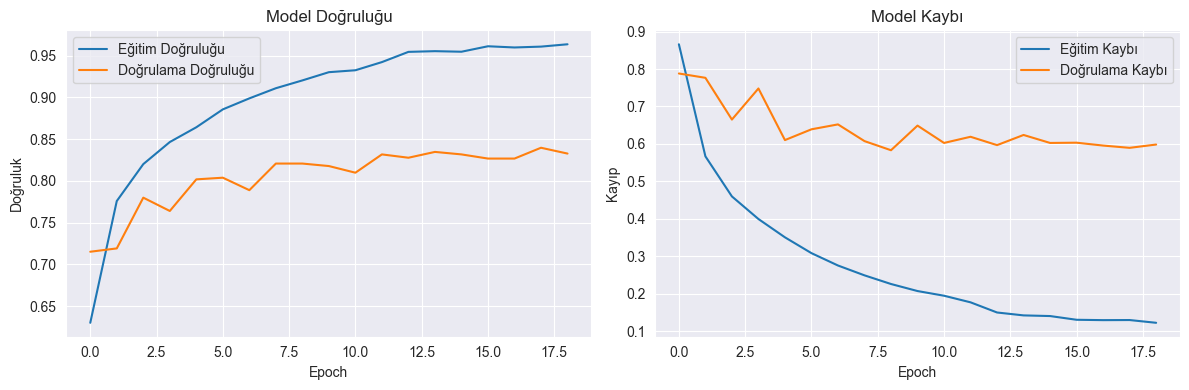

In [7]:
# Eğitim sonuçlarını görselleştir
plt.figure(figsize=(12, 4))#12X4 LÜK GRAFİK PENCERESİ OLUŞTUR.

#Accuracy Grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

#Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 0.8752
F1 Score: 0.8780
ROC-AUC Score: 0.9422


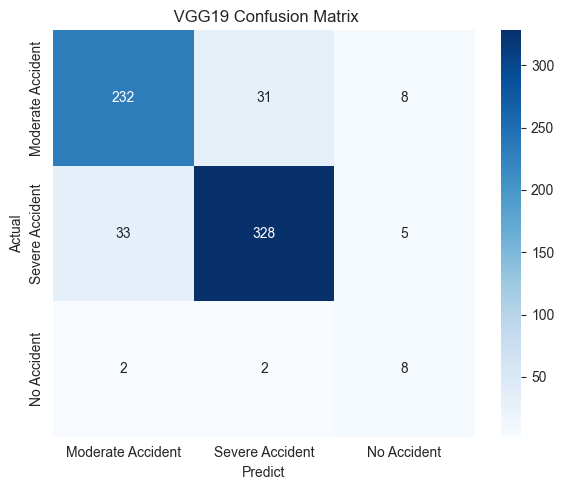


Per-Class Performance Metrics
                   precision    recall  f1-score   support

Moderate Accident       0.87      0.86      0.86       271
  Severe Accident       0.91      0.90      0.90       366
      No Accident       0.38      0.67      0.48        12

         accuracy                           0.88       649
        macro avg       0.72      0.81      0.75       649
     weighted avg       0.88      0.88      0.88       649



In [24]:
y_true = []
y_pred = []
y_proba = []

class_names = ['Moderate Accident', 'Severe Accident', 'No Accident']

for images, labels in test_dataset:
    probs = model.predict(images, verbose =0)#verbose ile çıktı gösterilmez.
    preds = np.argmax(probs, axis=1)
    trues = np.argmax(labels.numpy(), axis=1)

    y_proba.extend(probs)
    y_true.extend(trues)
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(tf.one_hot(y_true, len(class_names)), y_proba, multi_class='ovr')

print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predict")
plt.ylabel("Actual")
plt.title(" VGG19 Confusion Matrix")
plt.tight_layout()
plt.show()

# Her sınıf için detaylı metrikler
print("\nPer-Class Performance Metrics")
print(classification_report(y_true, y_pred, target_names=class_names))